# Generative Adversarial Networks

In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np

from torchvision.datasets import mnist, cifar
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from random import sample
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from IPython import display

First lets get some data ready

In [2]:
class DataLoad():
    
    def __init__(self):
        pass
    
    def load_data_mnist(self, batch_size=128):
        
        mnist_data = mnist.MNIST(root = './data/mnist',
                                train = True,
                                download = True,
                                transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])]))
        
        # Comment this line out if you wish to use the full dataset.
        mnist_data = torch.utils.data.Subset(mnist_data, sample(list(range(0,30000)), batch_size*100)) 
        
        mnist_loader = DataLoader(mnist_data, 
                                  batch_size = batch_size, 
                                  shuffle=True)
        
        return mnist_loader
    
    def load_data_cifar10(self, batch_size=128):
        
        cifar_data = cifar.CIFAR10(root = './data/cifar10',
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])]))
        
        # Comment these two lines out if you wish to use the full dataset.
        sample_range = sample(list(range(0,25000)), batch_size*120)
        cifar_data = torch.utils.data.Subset(cifar_data, sample_range)
        
        cifar_loader = DataLoader(cifar_data,
                                  batch_size = batch_size,
                                  shuffle = True)
        
        return cifar_loader 

In [3]:
def load_data(ds):
    
    # Initialize the dataloader
    data_loader = DataLoad()
    
    # Load training data into the dataloader
    if ds == 'mnist':
        train_loader = data_loader.load_data_mnist(batch_size = batch_size)
    elif ds == 'cifar10':
        train_loader = data_loader.load_data_cifar10(batch_size = batch_size)
    
    return train_loader



As we discussed in class, GANs are composed of two models, represented by neural networks:
* The first model is called a **Generator** and it aims to generate new data similar to the expected one. 
* The second model is named the **Discriminator** and it aims to recognize if an input data is ‘real’ — belongs to the original dataset — or if it is ‘fake’ — generated by a forger.


* **Generator Network**: The input to the generator is a series of randomly generated numbers called **latent sample**. It tries to produce data that come from some probability distribution. The generator network takes random noise as input, then runs that noise through a differentiable function to transform the noise and reshape it to have recognizable structure. The output of the generator network ia a realistic image. Without training, the generator produces garbage images only. 
    
    So z (latent sample, vector of unstructured noise) is essentially a vector of unstructured noise. It’s a source of randomness that allows the generator to output a wide variety of different vectors.


* **Discriminator Network**: The discriminator is a **classifier** trained using the **supervised learning**. It classifies whether an image is real (1) or is fake (0).


* **Training GANs: Two player game**: The Generator (forger) needs to learn how to create data in such a way that the Discriminator isn’t able to distinguish it as fake anymore. The competition between these two teams is what improves their knowledge, until the Generator succeeds in creating realistic data.

    $G$ try to fool discriminator by generating real-looking images.

    $D$ try to distinguish between real and fake images.

    Train jointly in **minimax game**
    
### Network Design

<p align="center">
    <img src="network_design_gan.png" width="600"\>
</p>


Below is our Generator model. Now that we've had some experience with building our own architectures, get creative and build your own hidden layers.

In [11]:
class Generator(nn.Module):
    
    def __init__(self, model_type, noise_dim=100):
        
        super(Generator, self).__init__()
        
        self.model_type = model_type
        self.image_shape = {'mnist': (1,28,28),
                           'cifar10': (3,32,32)}
        
        self.models = nn.ModuleDict({
            
            'mnist': nn.Sequential(
                            nn.Linear(noise_dim, 128, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            # TODO: fill in `None` values and build your 
                            #       hidden layers.
                            nn.Linear(128, 256),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256, 512),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512, int(np.prod(self.image_shape[model_type]))),
                            nn.Tanh(),
                            ),
            
            'cifar10': nn.Sequential(
                            nn.Linear(noise_dim, 128, bias = True),
                            nn.LeakyReLU(0.2, inplace=True),
                            # TODO: fill in `None` values and build your 
                            #       hidden layers.
                            nn.Linear(128, 256),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256, 512),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(512, int(np.prod(self.image_shape[model_type]))),
                            nn.Tanh()                
                            ),
                })
        
    def forward(self, z):
        img = self.models[self.model_type](z)
        img = img.view(img.size(0), *self.image_shape[self.model_type])            
        return img

Also build your hidden layers for the Discriminator. Dont forget to fill any `None` values you see.

In [5]:
class Discriminator(nn.Module):
    
    def __init__(self, model_type):
        
        super(Discriminator, self).__init__()
        
        self.model_type = model_type
        self.image_shape = {'mnist': (1,28,28),
                           'cifar10': (3,32,32)}
        
        self.models = nn.ModuleDict({
            'mnist': nn.Sequential(
                            nn.Linear(int(np.prod(self.image_shape[model_type])),512),
                            nn.LeakyReLU(0.2, inplace=True),
                            # TODO: Build your hidden layers. Remember to fill any 
                            #       `None` values you see.
                            nn.Linear(512, 256),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256, 128),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(128,1), # How many values should the Discriminator output?
                            nn.Sigmoid(),
                ),
            
            'cifar10': nn.Sequential(
                            nn.Linear(int(np.prod(self.image_shape[model_type])),512),
                            nn.LeakyReLU(0.2, inplace=True),
                            # TODO: Build your hidden layers. Remember to fill any 
                            #       `None` values you see.
                            nn.Linear(512, 256),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(256, 128),
                            nn.LeakyReLU(0.2, inplace=True),
                            nn.Linear(128,1), # How many values should the Discriminator output?
                            nn.Sigmoid(),
                ),
            })
        
    def forward(self, img):        
        img_flat = img.view(img.size(0),-1)
        output = self.models[self.model_type](img_flat)        
        return output

In [6]:
# Use GPU if available
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if cuda else 'cpu'
device

'cpu'

Below are the initial hyperparameters for training. Expect to return to this cell for tuning.

In [7]:
batch_size = 32
beta1 = 0.5
beta2 = 0.999

total_epochs = 100
learning_rate = 1e-3
noise_dim = 100
k = 5

In [8]:
# Generate some fixed noise to use down the road.
noise_dim = 100
fixed_noise = torch.randn(16, noise_dim, device=device)

# Set real/fake designations:

real = float(1)
fake = float(0)

### Cost function

Minimax objective function (Value Function or Cost Function of Minimax Game played by Generator and Discriminator):

$$ \underset{\theta_{g}}{min} \: \underset{\theta_{d}}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D_{\theta_{d}}(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D_{\theta_{d}}(G_{\theta_{g}}(z)))]$$

* $D_{\theta_{d}}$ wants to maximize  objective such that $D(x)$ is close to 1 (real) and $D(G(z))$ is close to 0 (fake).
* $G_{\theta_{g}}$ wants to minimize objective such that $D(G(z))$ is close to 1 (discriminator is fooled into thinking generated G(z) is real).

Alternate between:
1. Gradient ascent on D
$$\underset{\theta_{d}}{max} [\mathbb{E}_{x\sim p_{data}(x)}log D_{\theta_{d}}(x) + \mathbb{E}_{z\sim p_{z}(z)}log(1 - D_{\theta_{d}}(G_{\theta_{g}}(z)))]$$

2. Instead: Gradient ascent on generator, different objective
$$\underset{\theta_{g}}{max}[\mathbb{E}_{z\sim p_{z}(z)}[log( D_{\theta_{d}}(G_{\theta_{g}}(z)))] $$

Instead of minimizing likelihood of discriminator being correct, now maximize likelihood of discriminator being wrong. Same objetive of fooling discriminator, but now higher gradient signal for bad samples => works much better!

As a result, 
* the Discriminator is trained to correctly classify the input data as either real or fake. 
    * This means it’s weights are updated as to maximize the probability that any real data input x is classified as belonging to the real dataset, while minimizing the probability that any fake image is classified as belonging to the real dataset. 
    * In more technical terms, the loss/error function used maximizes the function D(x), and it also minimizes D(G(z)).
* the Generator is trained to fool the Discriminator by generating data as realistic as possible, which means that the Generator’s weight’s are optimized to maximize the probability that any fake image is classified as belonging to the real dataset. Formally this means that the loss/error function used for this network maximizes D(G(z)).

In [9]:
# Load training data:
dataset = 'cifar10' # 'mnist' or 'cifar10'
train_loader = load_data(dataset)

Files already downloaded and verified


In [12]:
# Loss function
criterion = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator(dataset)
discriminator = Discriminator(dataset)

if cuda:
    generator.cuda()
    discriminator.cuda()
    criterion.cuda()

# Optimizers
optimizer_generator = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (beta1, beta2))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (beta1, beta2))

Below is the training procedure, but with `None` values sprinked throughout. 

*TODO*:
* Replace `None` values with necessary objects.
* Collect losses in lists for further analysis.

On execution, the image grid will update after each epoch. Watch your images update and make note of how they evolve throughout training.

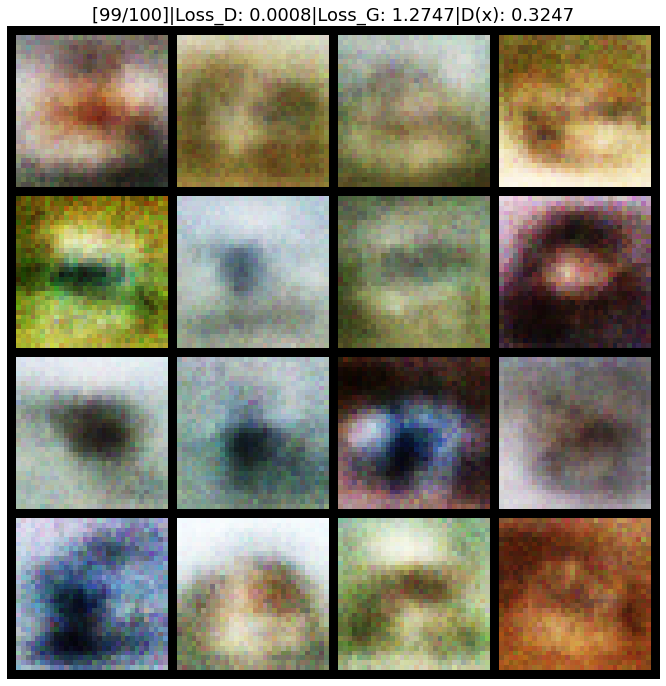

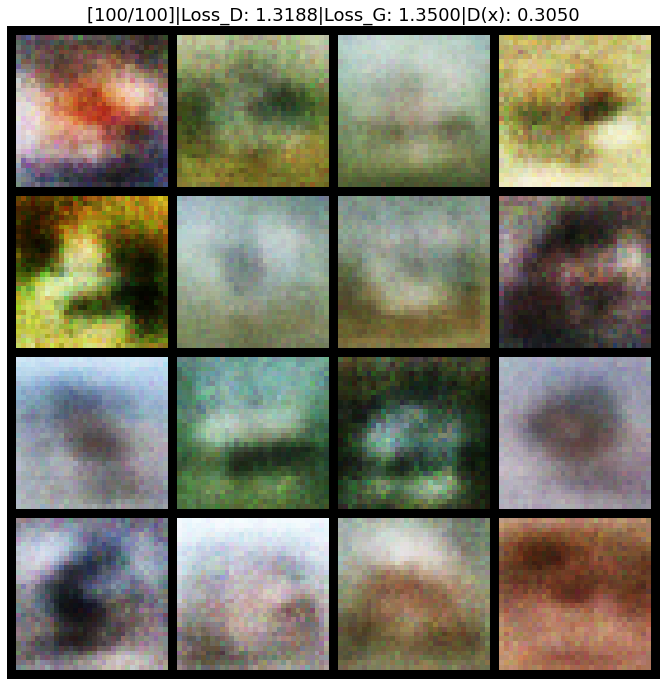

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off')


loss_generator = []
loss_discriminator = []


# Training Loop

for epoch in range(total_epochs):
    # update the discriminator k times before updating the generator
    for i, (imgs, _) in enumerate(train_loader):
        
        imgs = imgs.to(device)
        
        # Set up some 'truth' variables here so that way the discriminator has something to check against.

        valid = Variable(torch.Tensor(imgs.size(0),1).fill_(real), requires_grad=False).to(device)
        false = Variable(torch.Tensor(imgs.size(0),1).fill_(fake), requires_grad=False).to(device)
        
        optimizer_discriminator.zero_grad()
        
        # Calculate the loss on the all-real batch
        # What do we want to be comparing our discriminator against?
        
        real_loss = criterion(discriminator(imgs), valid)
        
        # Generate some random noise
        # What kind of distribution do we want to be using for this? (replace the None in the next line with the answer)
        
        noise = Variable(torch.Tensor(np.random.normal(0,1, (imgs.shape[0], noise_dim)))).to(device)
        
        # We want some fake images here from the noise, how would we create them?
        gen_imgs = generator(noise)
        
        # Now we examine how well our discriminator does against the false data, so thus
        fake_loss = criterion(discriminator(gen_imgs.detach()), false)
        
        # Now we need to have the loss for our discriminator. How would we do this?
        
        loss_D = real_loss + fake_loss
        loss_discriminator.append(loss_D.detach().cpu().numpy())
        
        # Calculate the gradients        
        loss_D.backward()
        
        # Update D
        optimizer_discriminator.step()
        
        
        # Update generator network: maximize log(D(G(z)))
        # This only fires after k steps of discriminator optimization
        
        if (epoch+1)%k == 0 or epoch == 0:
            optimizer_generator.zero_grad()

            # We need to now update our generator. What would the first step here?

            gen_imgs = generator(noise)
            output = discriminator(gen_imgs)

            # Now we need to calculate the probability of the discriminator classifying the fake images as real
            # If this probability is close to 0, then the generator has learnt how to fool the discriminator

            D_x = output.mean().item()

            # What information would we want to have in order to properly update our generator?

            loss_G = criterion(output, valid)
            loss_generator.append(loss_G.detach().cpu().numpy())
            
            # Calculate gradients for the generator:
            loss_G.backward()

            # Update  the generator
            optimizer_generator.step()

            
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    loss_discriminator.append(loss_D.item())
    if (epoch+1) % k == 0 or epoch == 0:
        loss_generator.append(loss_G.item())
    else:
        loss_generator.append(None)

    fake_sample = generator(fixed_noise)
    image_grid = make_grid(fake_sample.to(device),
                           padding=2,
                           nrow=4,
                           normalize = True)
    ax.imshow(image_grid.cpu().permute(1,2,0))
    ax.set_title('[%d/%d]|Loss_D: %.4f|Loss_G: %.4f|D(x): %.4f'
                % (epoch+1, total_epochs, 
                    loss_D.item(),
                    loss_G.item(),
                    D_x),
                size=18)

What did you notice about your images as they updated? How would you describe the final result?

The images became more distinguishable from each other as they updated. They alll started out as greyish random noise but eventually took on their distinct own shapes and colors.

*TODO*:
* Plot your generator and discriminator errors.
* Explain how these errors support your qualitative assessment of the images rendered.
* Return to your model arch. How might changing your architecture improve your result? Make those adjustments to your Discriminator and/or Generator models.
* Return to the model hyperparameters. You may notice one or more may be sub-optimal. Adjust values and rerun the training loop. How do these adjustments improve/degrade your previous result? Why?

Adding more layers improved the results (moving up from 2 linear layers to 4 made big improvements in creating more distinct images). It seems like more layers for the generator specifically is more important than adding more layers to the discriminator.

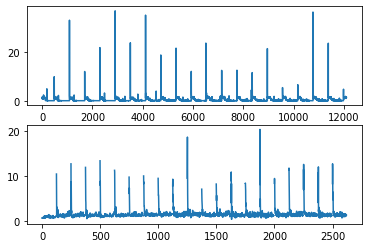

In [14]:
# plot loss_discriminator and loss_generator
fig,axs = plt.subplots(2)
axs[0].plot(range(len(loss_discriminator)),loss_discriminator)
axs[1].plot(range(len(loss_generator)),loss_generator)

Discriminator gets updated at every step but the generator gets updated every 5 steps. Since the generator affects the discriminator loss, we see similar peaks throughout epochs as the generator updates.

## BONUS

CIFAR is an interesting dataset and can yield interesting images for generative networks-- but can require more involved model tuning to get realistic output. 

You'll notice the code in this notebook has been built to additionally support the MNIST dataset. Copy the necessary cells to below, and rerun the training with `dataset = 'mnist'`. Now watch your images update. Does this datatset yield a faster time-to-realism? What does this day about the dataset and latent space?